In [13]:
# First preprocessing cut ROI from the image

> Cut only the ROI from the image

In [14]:
#| default_exp preprocessing.cut_roi

In [15]:
#| hide
%load_ext autoreload
%autoreload 2	


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
#| export
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import shutil
import os
from fastcore.all import *
import cv2
from typing import List 

In [17]:
import matplotlib as mpl
mpl.rcParams['image.cmap']='gray'

In [18]:
#| export
from cv_tools.core import *

In [19]:
data_path = Path(os.getenv('DATA_PATH'), 'crack_detect_usm')
data_path.ls()

(#13) [Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig2.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig2'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/models_pt'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/temp'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig1'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/models'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig4.parquet'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/test_data_sig3')...]

In [20]:
#| hide
good_im_path = Path(data_path, 'good')
tst_im_path = Path(data_path, 'test_data_sig1')
tst_im2_path = Path(data_path, 'test_data_sig2')
tst_im3_path = Path(data_path, 'test_data_sig3')
tst_im4_path = Path(data_path, 'test_data_sig4')
tmp_sig1_path = Path(data_path, 'temp/sig1')
tmp_sig2_path = Path(data_path, 'temp/sig2')
tmp_sig3_path = Path(data_path, 'temp/sig3')
tmp_sig4_path = Path(data_path, 'temp/sig4')
tmp_sig1_path.mkdir(exist_ok=True, parents=True)
tmp_sig2_path.mkdir(exist_ok=True, parents=True)
tmp_sig3_path.mkdir(exist_ok=True, parents=True)
tmp_sig4_path.mkdir(exist_ok=True, parents=True)
good_im_path.ls(), tst_im_path.ls()

((#19106) [Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81834702_02_DCB-2932306405550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81705396_01_DCB-0712345182450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81756453_02_DCB-1482319866450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81707405_01_DCB-1312301164550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81720270_01_DCB-1582307722550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81759009_01_DCB-1532342654450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/DCB-1382387950450663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/DCB-1312306704550663_a.png'),Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/good/81759011_02_DCB-1612348130450663_a.png'),Path('/home/hasan/Schreibtisch/projects/d

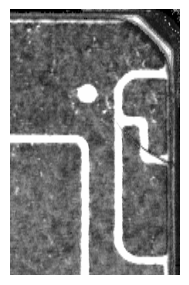

In [21]:
#| hide
im4_img = read_img(Path(tst_im4_path).ls()[0])
show_(im4_img[55:400, 500:720])
#cv2.imwrite(f'{tmp_sig4_path}/template.png', im4_img[55:400, 500:720])

In [22]:
#| hide
tmp_sig1_img = read_img(Path(tmp_sig1_path).ls()[0])
tmp_sig2_img = read_img(Path(tmp_sig2_path).ls()[0])
tmp_sig3_img = read_img(Path(tmp_sig3_path).ls()[0])
tmp_sig4_img = read_img(Path(tmp_sig4_path).ls()[0])

In [23]:
#| hide
tmp_sig1_img.shape, tmp_sig2_img.shape, tmp_sig3_img.shape, tmp_sig4_img.shape

((466, 310), (310, 240), (420, 220), (345, 220))

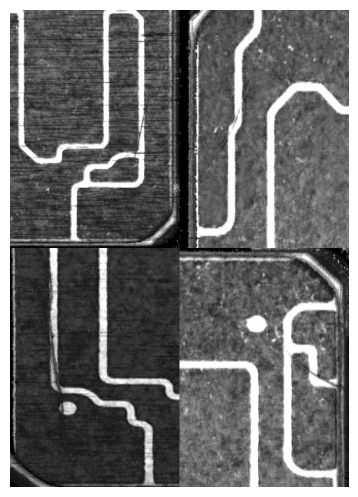

In [24]:
#| hide
show_(concat_images([tmp_sig1_img, tmp_sig2_img, tmp_sig3_img, tmp_sig4_img], rows=2, cols=2, number='3'))

In [25]:
#| hide
sm_img = tst_im_path.ls()[0]
img = read_img(sm_img)

# Testing one good image with template and roi

In [74]:
#| export
def frm_full_img_to_splits(
        im_path:Union[str, Path], # Path to full image
		template_img:List[np.ndarray],# List of 4 template images starting 1-4
		save_path:Union[str, Path]=None, # Path to save cutted images
		show:bool=False

		): 
		
  'Cut ROI from full image'
  img = read_img(im_path, gray=True)
  for idx, i in enumerate(template_img):
    x, y, w, h = get_template_part(img, tmp_img=i)
    tmp_part = img[y:y+h, x:x+w]
    if show: 
        show_(tmp_part)
    if save_path is not None:
		# as signatture starts with idx 1, so idx +1 is used
        cv2.imwrite(f'{save_path}/{Path(im_path).stem}_sig_{idx+1}.png', tmp_part)



In [71]:
#| export
def frm_full_img_to_splits_folder(
        im_path:Union[str, Path], # folder path where all images needs to be spllit
		template_img:List[np.ndarray],# List of 4 template images starting 1-4
		save_path:Union[str, Path]=None, # Path to save cutted images

   	):
	'loop through all images in folder and cut ROI from full image'

	if save_path is not None:
		Path(save_path).mkdir(exist_ok=True, parents=True)
	parallel(
		partial(frm_full_img_to_splits, template_img=template_img, save_path=save_path),
		Path(im_path).ls(),
		progress=True,
		n_workers=8
	)

	#for i in tqdm(Path(im_path).ls(),total=len(Path(im_path).ls())):
		#frm_full_img_to_splits(i, template_img, save_path=save_path)

In [63]:
tmp_sig1_path

Path('/home/hasan/Schreibtisch/projects/data/crack_detect_usm/temp/sig1')

In [64]:
#| export
def parse_args_():

	import argparse
	parser = argparse.ArgumentParser(description='Cut ROI from the image')
	parser.add_argument('--im_path', type=str, help='Path to full image')
	parser.add_argument(
		'--tmp_img1', 
		type=str, 
		default='/home/hasan/Schreibtisch/projects/data/crack_detect_usm/temp/sig1',
		help='signature 1 template image path only path not with image name')
	parser.add_argument(
		'--tmp_img2', 
		type=str, 
		default='/home/hasan/Schreibtisch/projects/data/crack_detect_usm/temp/sig2',
		help='signature 2 template image path')
	parser.add_argument(
		'--tmp_img3', 
		type=str, 
		default='/home/hasan/Schreibtisch/projects/data/crack_detect_usm/temp/sig3',
		help='signature 3 template image path')
	parser.add_argument(
		'--tmp_img4', 
		type=str, 
		default='/home/hasan/Schreibtisch/projects/data/crack_detect_usm/temp/sig4',
		help='signature 4 template image path')
	parser.add_argument('--save_path', type=str, help='Path to save cutted images')

	args = parser.parse_args()
	return args

In [65]:
#| export
def main_():
	args = parse_args_()
	tmp_sig1_img = read_img(Path(args.tmp_img1).ls()[0])
	tmp_sig2_img = read_img(Path(args.tmp_img2).ls()[0])
	tmp_sig3_img = read_img(Path(args.tmp_img3).ls()[0])
	tmp_sig4_img = read_img(Path(args.tmp_img4).ls()[0])
	frm_full_img_to_splits_folder(
		im_path=args.im_path,
		template_img=[tmp_sig1_img, tmp_sig2_img, tmp_sig3_img, tmp_sig4_img],
		save_path=args.save_path
	)

	

In [57]:
frm_full_img_to_splits(
    tst_im_path.ls()[0],
	template_img=[tmp_sig1_img, tmp_sig2_img, tmp_sig3_img, tmp_sig4_img],

)

In [ ]:
#| export
if __name__ == '__main__':
	main_()

In [2]:
#| hide
import nbdev

In [3]:
#| hide
nbdev.nbdev_export('02_preprocess.cut_roi.ipynb')